In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install opendatasets --upgrade --quiet

In [ ]:
# Importing Libraries

# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
import opendatasets as od
from datetime import datetime
import calendar
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# Utilities
#from viz_utils import *
#from custom_transformers import *
#from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [ ]:
customers_dataset_path='/content/drive/MyDrive/olist_customers_dataset.csv'
geolocation_dataset_path='/content/drive/MyDrive/olist_geolocation_dataset.csv'
order_items_dataset_path='/content/drive/MyDrive/olist_order_items_dataset.csv'
order_reviews_dataset_path='/content/drive/MyDrive/olist_order_reviews_dataset.csv'
order_payments_dataset_path='/content/drive/MyDrive/olist_order_payments_dataset.csv'
orders_dataset_path='/content/drive/MyDrive/olist_orders_dataset.csv'
products_dataset_path='/content/drive/MyDrive/olist_products_dataset.csv'
sellers_dataset_path='/content/drive/MyDrive/olist_sellers_dataset.csv'
product_cat_path='/content/drive/MyDrive/product_category_name_translation.csv'

In [ ]:
data=pd.read_csv(customers_dataset_path)
geo_data=pd.read_csv(geolocation_dataset_path)
order_itemdata=pd.read_csv(order_items_dataset_path)
rev_data=pd.read_csv(order_reviews_dataset_path)
pay_data=pd.read_csv(order_payments_dataset_path)
orders=pd.read_csv(orders_dataset_path)
order_prddata=pd.read_csv(products_dataset_path)
order_selldata=pd.read_csv(sellers_dataset_path)
order_prd_catdata=pd.read_csv(product_cat_path)

In [ ]:
#checking number of columns , column_names and no_of_rows

datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]



info_df = pd.DataFrame({},)
info_df['dataset']= titles

info_df['no_of_columns']= [len(df.columns) for df in datasets ]
info_df['columns_name']= [', '.join(list(df.columns)) for df in datasets] 
info_df['no_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='Greys')

,dataset,no_of_columns,columns_name,no_of_rows
0,customers,5,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441
1,geolocations,5,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163
2,items,7,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650
3,payments,5,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886
4,orders,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441
5,products,9,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951
6,reviews,7,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224
7,sellers,4,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095
8,category_translation,2,"product_category_name, product_category_name_english",71


## Observations
##### dataset with max columns is products
#####dataset with max rows id geo location

In [ ]:
#checking dtypes
datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = pd.DataFrame({},)
new_df['dataset']= titles

new_df['numeric_features'] = [len((df.select_dtypes(include=numerics)).columns) for df in datasets]
new_df['num_features_name'] = [', '.join(list((df.select_dtypes(include=numerics)).columns)) for df in datasets]
new_df['object_features'] = [len((df.select_dtypes(include='object')).columns) for df in datasets]
new_df['objt_features_name'] = [', '.join(list((df.select_dtypes(include='object')).columns)) for df in datasets]
new_df['bool_features'] = [len((df.select_dtypes(include='bool')).columns) for df in datasets]
new_df.style.background_gradient(cmap='Greys')

,dataset,numeric_features,num_features_name,object_features,objt_features_name,bool_features
0,customers,1,customer_zip_code_prefix,4,"customer_id, customer_unique_id, customer_city, customer_state",0
1,geolocations,3,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng",2,"geolocation_city, geolocation_state",0
2,items,3,"order_item_id, price, freight_value",4,"order_id, product_id, seller_id, shipping_limit_date",0
3,payments,3,"payment_sequential, payment_installments, payment_value",2,"order_id, payment_type",0
4,orders,0,,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",0
5,products,7,"product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",2,"product_id, product_category_name",0
6,reviews,1,review_score,6,"review_id, order_id, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",0
7,sellers,1,seller_zip_code_prefix,3,"seller_id, seller_city, seller_state",0
8,category_translation,0,,2,"product_category_name, product_category_name_english",0


In [ ]:
#checking no of null values
#code source-https://www.kaggle.com/fayhosseini/brazilian-e-commerce-eda-for-beginners

datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]

info_df_n = pd.DataFrame({},)

info_df_n['dataset']= titles

#creating column of name of columns in the dataset 
info_df_n['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]

#creating total number of columns in the dataset 
info_df_n['cols_no']= [df.shape[1] for df in datasets]

#counting total null values
info_df_n['null_no']= [df.isnull().sum().sum() for df in datasets]

#creating total number of columns in the dataset with null-values 
info_df_n['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

#creating column of name of columns in the dataset with null-values 
info_df_n['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df_n.style.background_gradient(cmap='Greys')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,geolocations,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
4,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
5,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
6,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",7,145903,2,"review_comment_title, review_comment_message"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",4,0,0,
8,category_translation,"product_category_name, product_category_name_english",2,0,0,


### Observation(s):

* The maximum number of null-values are present in reviews dataset and the name of the columns with the null-values are review_comment_title and review_comment_message.
* products dataset contains least number of null- values but most of its columns has null-values.
* we have to deal with these null-values in future.

In [ ]:
rev_new = rev_data.drop(['review_comment_title','review_creation_date','review_id','review_answer_timestamp'],axis=1)

In [ ]:
#merge data frames
df = pd.merge(orders,pay_data, on="order_id")
df = df.merge(data, on="customer_id")
df = df.merge(order_itemdata, on="order_id")
df = df.merge(order_prddata, on="product_id")
df = df.merge(order_prd_catdata, on="product_category_name")
df = df.merge(rev_new, on="order_id")
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,Deveriam embalar melhor o produto. A caixa vei...
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,5,"Só achei ela pequena pra seis xícaras ,mais é ..."


In [ ]:
print("Number of rows after merging:",len(df))
print("Number of columns after merging:",len(df.columns))

Number of rows after merging: 115609
Number of columns after merging: 33


In [ ]:
#handling missing values
df.isnull().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   14
order_delivered_carrier_date      1195
order_delivered_customer_date     2400
order_estimated_delivery_date        0
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_category_name                0
product_name_lenght                  0
product_description_lenght           0
product_photos_qty       

Handling Missing values in Timestamps

* The order of different types of timestamps are shown below:


    order_purchase_timestamp-->order_approved_at--> order_delivered_carrier_date-->order_delivered_customer_date-->order_estimated_delivery_dat
    e     

* Timestamps containg missing values are order_approved_at, order_delivered_carrier_date, order_delivered_customer_date.

* null-values in order_approved_at can be replaced by order_purchase_timestamp and null-values in order_delivered_customer_date can be replaced by order_estimated_delivery_date 
* we can drop the column order_delivered_carrier_date.

In [ ]:
#Handling missing values
index = (df[df['order_delivered_customer_date'].isnull() == True].index.values)

df["order_approved_at"].fillna(df["order_purchase_timestamp"], inplace=True)
df["order_delivered_customer_date"].fillna(df["order_estimated_delivery_date"], inplace=True)

#dropping order delivery carrier date
df.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [ ]:
# Handling missing values of numerical features
df['product_weight_g'].fillna(df['product_weight_g'].median(),inplace=True)
df['product_length_cm'].fillna(df['product_length_cm'].median(),inplace=True)
df['product_height_cm'].fillna(df['product_height_cm'].median(),inplace=True)
df['product_width_cm'].fillna(df['product_width_cm'].median(),inplace=True)

In [ ]:
#Handling missing values of text column
print("Percentage of null reviews :",(df.review_comment_message.isnull().sum()/len(df))*100 ,"%")
# filling null value of review comments with no_review
df['review_comment_message'].fillna('nao_reveja',inplace=True)

Percentage of null reviews : 57.697065107387836 %


In [ ]:
#Find duplicate rows if any
dup_rows = df[df.duplicated(['order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date','customer_unique_id','review_comment_message'])]
dup_rows.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
8,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,2,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja
9,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,3,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja
10,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,4,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja


In [ ]:
print("Number of rows after dedublication:",len(df))
print("Number of columns after deduplication:",len(df.columns))

Number of rows after dedublication: 115609
Number of columns after deduplication: 32


In [ ]:
# all time stamps are in object dtype as observed above converting it into dataetime 
df[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date',]]=df[['order_purchase_timestamp',
       'order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115609 non-null  object        
 1   customer_id                    115609 non-null  object        
 2   order_status                   115609 non-null  object        
 3   order_purchase_timestamp       115609 non-null  datetime64[ns]
 4   order_approved_at              115609 non-null  datetime64[ns]
 5   order_delivered_customer_date  115609 non-null  datetime64[ns]
 6   order_estimated_delivery_date  115609 non-null  datetime64[ns]
 7   payment_sequential             115609 non-null  int64         
 8   payment_type                   115609 non-null  object        
 9   payment_installments           115609 non-null  int64         
 10  payment_value                  115609 non-null  float64       
 11  

In [ ]:
df.describe()

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000
mean,1.093747,2.946233,172.387379,35061.537597,1.194535,120.619850,20.056880,48.766541,785.808198,2.205373,2113.895467,30.307857,16.638445,23.113140,4.034409
std,0.729849,2.781087,265.873969,29841.671732,0.685926,182.653476,15.836184,10.034187,652.418619,1.717771,3781.740826,16.211046,13.473516,11.755036,1.385584
min,1.000000,0.000000,0.000000,1003.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000
25%,1.000000,1.000000,60.870000,11310.000000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,4.000000
50%,1.000000,2.000000,108.050000,24241.000000,1.000000,74.900000,16.320000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,5.000000
75%,1.000000,4.000000,189.480000,58745.000000,1.000000,134.900000,21.210000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,5.000000
max,29.000000,24.000000,13664.080000,99980.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,5.000000


In [ ]:
# checking the target variables i.e review score 
df.review_score.value_counts()

5    65374
4    21951
1    14546
3     9718
2     4020
Name: review_score, dtype: int64

In [ ]:
def partition(x):
    if x < 3:
        return 0
    return 1
df['review_score']=df['review_score'].map(lambda cw : partition(cw) ) 
    
# checking the review score now
df.review_score.value_counts()

1    97043
0    18566
Name: review_score, dtype: int64

Total Positive Reviews : 97043 , ( 83.94069665856463 %)
Total Negative Reviews : 18566 , ( 16.059303341435356 %)




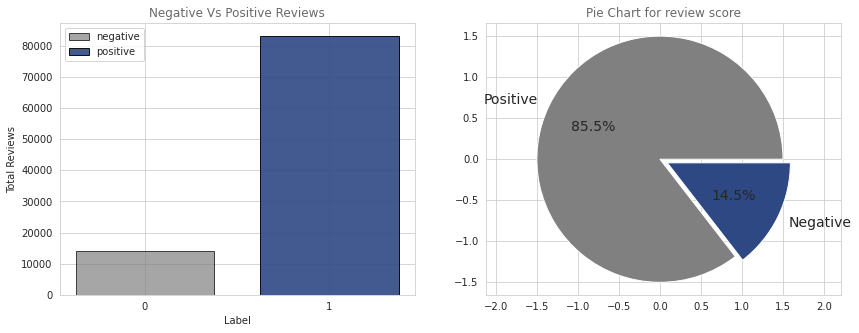

In [ ]:
#counting the review score with 1 and 0
y_value_counts = df.review_score.value_counts()

#calculating the percentage of each review type
print("Total Positive Reviews :", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Total Negative Reviews :", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print('\n')

#plotting bar-plot and pie chart
%matplotlib inline
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total Reviews')
plt.xlabel('Label')
plt.title('Negative Vs Positive Reviews',color='dimgrey')
plt.xticks([10,10.20],['0','1'])
#creating bar plots
plt.bar(10,14112, color = 'grey', width = 0.15,alpha=0.7,label='negative',edgecolor='black')
plt.bar(10.20,83143,color = '#2e4884', width = 0.15,alpha=0.9,label='positive',edgecolor='black')
plt.legend()

plt.subplot(1,2,2)
labels = ['Positive','Negative']
sizes = [83143,14112]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
color={'#2e4884','grey'}
plt.pie(sizes,explode=explode ,colors=color,labels=labels, autopct='%1.1f%%',shadow=False, startangle=0,radius=1.5,labeldistance=1.1,textprops={'fontsize': 14},frame=True, )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart for review score',color='dimgrey')
plt.show()

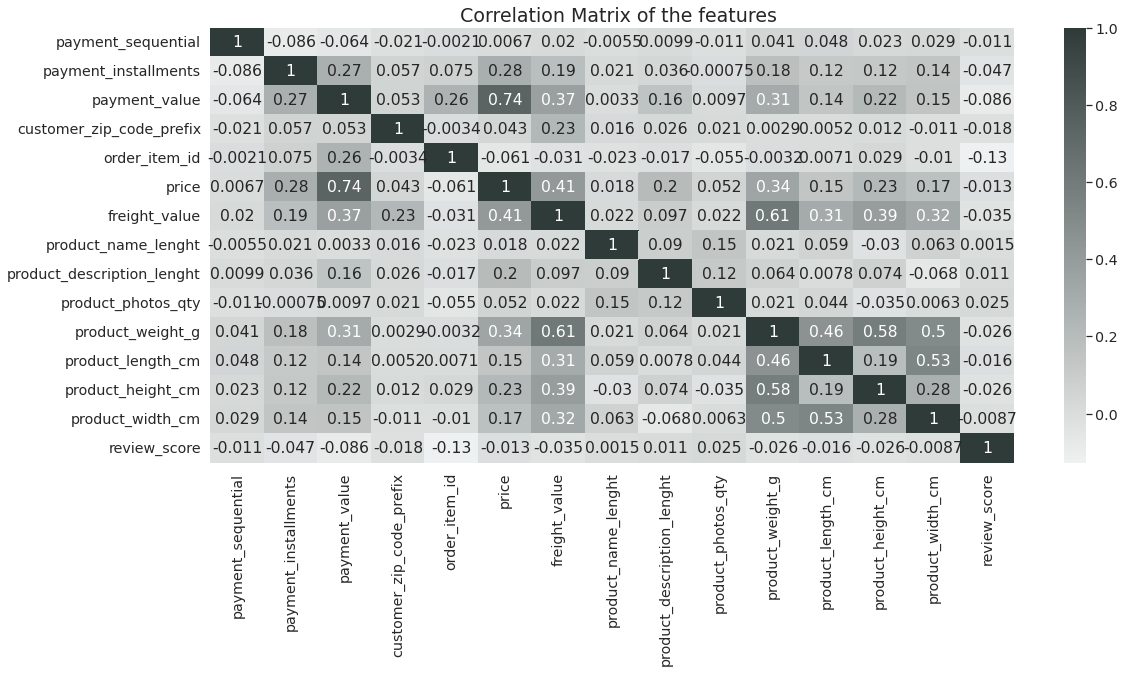

In [ ]:
#Correlation matrix 
corr_matrix = df.corr()
plt.figure(figsize=(18,8))
sns.set(font_scale=1.3)
cmap = sns.light_palette("#2f3b39",as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap,annot=True)
plt.title("  Correlation Matrix of the features",fontsize=19)
plt.savefig('plot16.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#finding corr- values of the features with review_score
corr_matrix["review_score"].sort_values(ascending=False)

review_score                  1.000000
product_photos_qty            0.025249
product_description_lenght    0.010676
product_name_lenght           0.001471
product_width_cm             -0.008671
payment_sequential           -0.010797
price                        -0.012648
product_length_cm            -0.016146
customer_zip_code_prefix     -0.017832
product_height_cm            -0.026055
product_weight_g             -0.026438
freight_value                -0.035055
payment_installments         -0.047238
payment_value                -0.085740
order_item_id                -0.127091
Name: review_score, dtype: float64

In [ ]:
#checking unique ids
print("Total number of unique seller_id:",len((df.seller_id).unique()))
print("Total number of unique product_id:",len((df.product_id).unique()))
print("Total number of unique customer_id:",len((df.customer_unique_id).unique()))

Total number of unique seller_id: 3028
Total number of unique product_id: 32171
Total number of unique customer_id: 93396


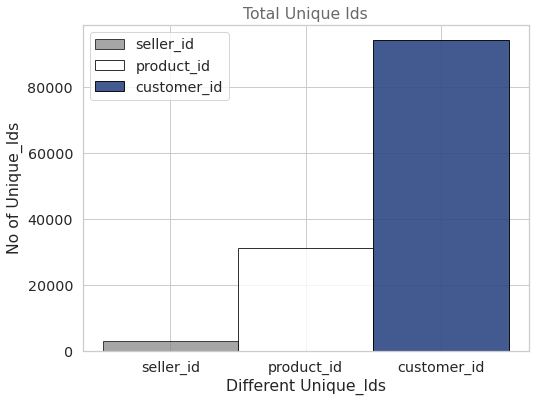

In [ ]:
%matplotlib inline
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
plt.ylabel('No of Unique_Ids')
plt.xlabel('Different Unique_Ids')
plt.title('Total Unique Ids',color='dimgrey')
plt.xticks([10,10.25,10.50],['seller_id','product_id','customer_id'])
#creating bar plots
plt.bar(10,3022, color = 'grey', width = 0.25,alpha=0.7,label='seller_id',edgecolor='black')
plt.bar(10.25,31053, color = 'white', width = 0.25,alpha=0.8,label='product_id',edgecolor='black')
plt.bar(10.50,94087, color = '#2e4884', width = 0.25,alpha=0.9,label='customer_id',edgecolor='black')
plt.legend()
plt.show()

In [ ]:
df.groupby('payment_type').size()

payment_type
boleto         22510
credit_card    85278
debit_card      1659
voucher         6162
dtype: int64

In [ ]:
df['payment_type'].value_counts()

credit_card    85278
boleto         22510
voucher         6162
debit_card      1659
Name: payment_type, dtype: int64

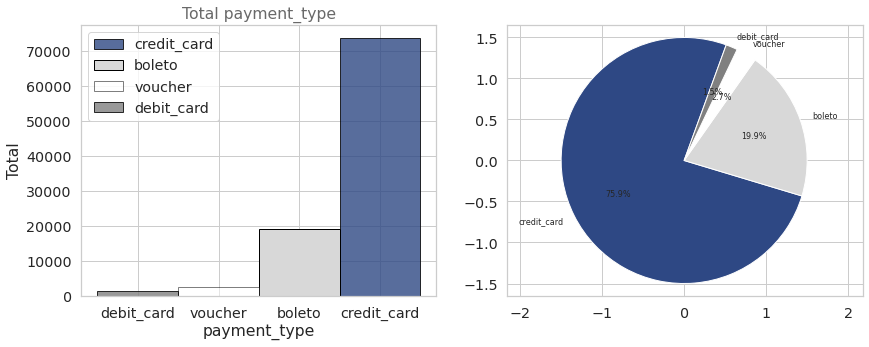

In [ ]:
%matplotlib inline
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total')
plt.xlabel('payment_type')
plt.title('Total payment_type',color='dimgrey')
plt.xticks([10,10.25,10.50,10.75],['debit_card','voucher','boleto','credit_card'])
#creating bar plots
plt.bar(10.75,73816, color = '#2e4884', width = 0.25,alpha=0.8,label='credit_card',edgecolor='black')
plt.bar(10.50,19345, color = '#d8d8d8', width = 0.25,label='boleto',edgecolor='black')
plt.bar(10.25,2604, color = 'white', width = 0.25,alpha=0.5,label='voucher',edgecolor='black')
plt.bar(10,1490, color = 'grey', width = 0.25,alpha=0.8,label='debit_card',edgecolor='black')



plt.legend()

plt.subplot(1,2,2)
s= [ 73816,19345, 2604,1490]
new = ['credit_card','boleto','voucher','debit_card']

explode = (0, 0, 0,0)  
colours = {'credit_card': '#2e4884',
           'boleto': '#d8d8d8',
           'voucher': 'w',
           'debit_card': 'grey'}

color ={'#2e4884','grey','#d8d8d8','w'}



plt.pie(s, explode=explode, labels=new,colors=[colours[key] for key in new] , autopct='%1.1f%%',shadow=False, startangle=70,radius=1.5,frame=True,textprops={'fontsize': 8})
plt.axis('equal') 
plt.show()

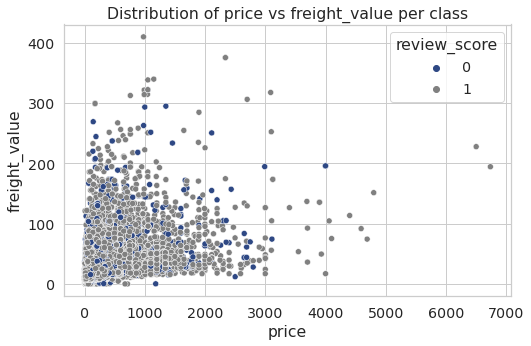

In [ ]:
# Distribution of price vs freight_value per class
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
ax = sns.scatterplot(x='price',y='freight_value', data = df, hue="review_score",palette=['#2e4884','grey'])
plt.title('Distribution of price vs freight_value per class')
plt.show()

In [ ]:
#Text analysis
# Reading in the reviews dataset
review_df = pd.read_csv(order_reviews_dataset_path)
review_df.head()
review_df.shape

(99224, 7)

In [ ]:
review_data_title = review_df['review_comment_title']
review_data = review_df.drop(['review_comment_title'],axis=1)

# Dropping NaN values
review_data  = review_data.dropna()
review_data_title = review_data_title.dropna()

In [ ]:
# Resetting the reviews index and visualizing the data
review_data = review_data.reset_index(drop=True)
review_data.head(3)
review_data.shape

(40977, 6)

In [ ]:
# Resetting the reviews titles index and visualizing the data
review_data_title = review_data_title.reset_index(drop=True)
review_data_title.head(3)
review_data_title.shape

(11568,)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
comments = []

stop_words = set(stopwords.words('portuguese'))


for words in review_data['review_comment_message']:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    comments.append(' '.join(filtered_result))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


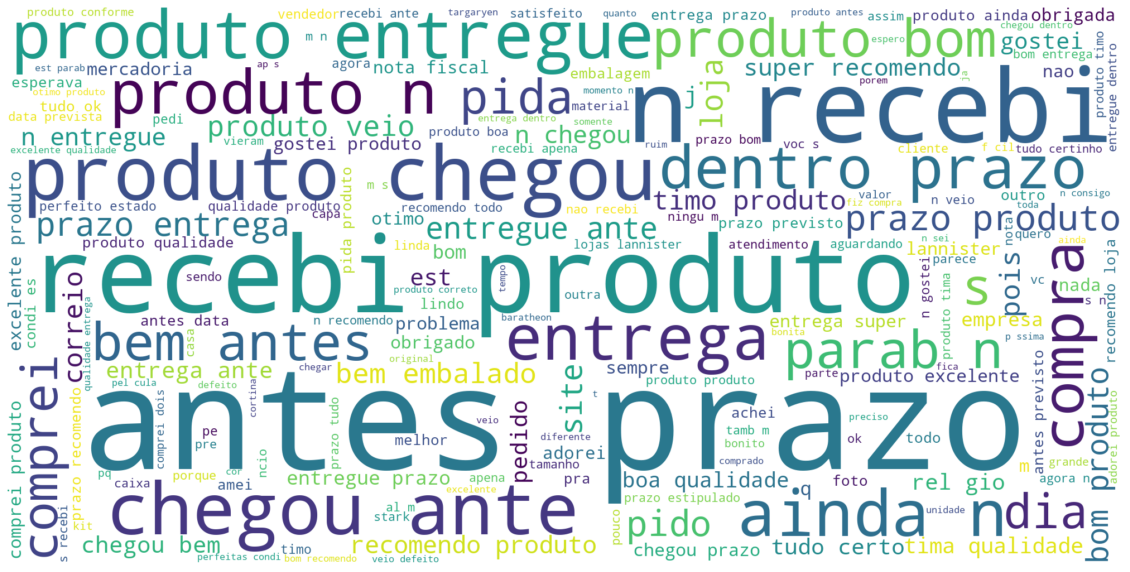

In [ ]:
#Using wordcloud to visualize the comments
unique_string=(" ").join(comments)
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('plot23.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
#further checking by Counting the words
from collections import Counter
words = (" ".join(review_data['review_comment_message'])).lower().split()
counts = Counter(words)

In [ ]:
print("Most frequent words:")
sorted(counts.items(), key=lambda x: x[1], reverse=True)[:15]

Most frequent words:


[('o', 18676),
 ('e', 15582),
 ('produto', 15462),
 ('a', 12133),
 ('de', 11296),
 ('do', 11139),
 ('não', 10614),
 ('que', 8271),
 ('muito', 7568),
 ('com', 5574),
 ('antes', 5533),
 ('entrega', 5363),
 ('chegou', 5130),
 ('prazo', 5043),
 ('no', 5038)]

In [ ]:
pip install googletrans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 1.4 MB 14.5 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 65 kB 3.1 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=cb83b362a65120c2d8ec1a2c78273ad91bad842da2f81c856005d6c0d8ebbcef
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


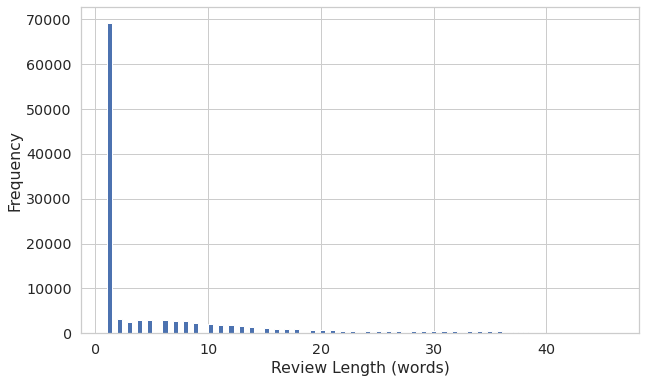

In [ ]:
# Getting the number of words by splitting them by a space
words_per_review = df.review_comment_message.apply(lambda x: len(x.split(" ")))
plt.figure(figsize=(10,6))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
PRESENT = datetime(2018,9,3)
rfm= df.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda date: (PRESENT - date.max()).days,
                                        'order_id': lambda num: len(num),
                                        'payment_value': lambda price: price.sum()})
rfm.columns=['recency','frequency','monetary']
rfm['recency'] = rfm['recency'].astype(int)
rfm['frequency'] = rfm['frequency'].astype(int)
rfm['monetary'] = rfm['monetary'].astype(float)

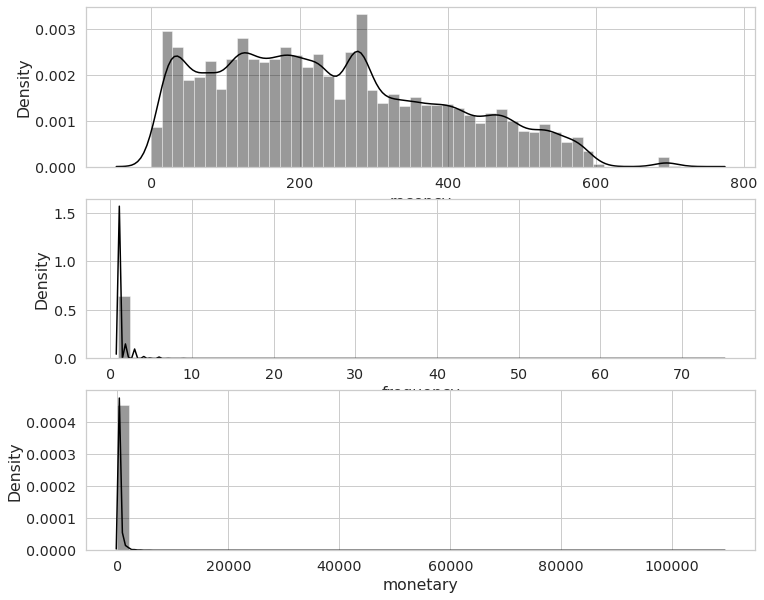

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm['recency'],color='black')
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm['frequency'],color='black')
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm['monetary'],color='black')
# Show the plot
plt.show()

In [ ]:
# Create labels for Recency and Frequency
def partition(x):
    if x < 10:
      return 1
    if 10<=x<=35:
      return 2
    if 35<x<=50:
      return 3
    if 50<x<=75:
      return 4      

rfm['f_quartile']=rfm['frequency'].map(lambda cw : partition(cw) ) 
    
# checking the review score now
rfm.f_quartile.value_counts()
r_labels = range(4, 0, -1);m_labels= range(1,5)

rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, r_labels)
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, m_labels)

In [ ]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,recency,frequency,monetary,f_quartile,r_quartile,m_quartile,RFM_Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,1,4,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,1,4,1,411
0000f46a3911fa3c0805444483337064,541,1,86.22,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,1,2,1,211
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,1,2,3,213


In [ ]:
rfm_count_unique = rfm.groupby('RFM_Score')['RFM_Score'].nunique()
print(rfm_count_unique.sum())
rfm['RFM_Score_s'] = rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)
print(rfm['RFM_Score_s'].head())

31
customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    8
0000b849f77a49e4a4ce2b2a4ca5be3f    6
0000f46a3911fa3c0805444483337064    4
0000f6ccb0745a6a4b88665a16c9f078    4
0004aac84e0df4da2b147fca70cf8255    6
Name: RFM_Score_s, dtype: int64


In [ ]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score_s'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score_s'] >= 8) and (df['RFM_Score_s'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score_s'] >= 7) and (df['RFM_Score_s'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score_s'] >= 6) and (df['RFM_Score_s'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score_s'] >= 5) and (df['RFM_Score_s'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score_s'] >= 4) and (df['RFM_Score_s'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,recency,frequency,monetary,f_quartile,r_quartile,m_quartile,RFM_Score,RFM_Score_s,RFM_Level
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,1,4,3,413,8,Champions
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,1,4,1,411,6,Potential
0000f46a3911fa3c0805444483337064,541,1,86.22,1,1,2,112,4,Needs Attention
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,1,2,1,211,4,Needs Attention
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,1,2,3,213,6,Potential


In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()

                   recency frequency monetary       
                      mean      mean     mean  count
RFM_Level                                           
Can't Loose Them      63.3       1.8    615.5   5966
Champions            114.5       1.4    350.5  11975
Loyal                172.0       1.3    268.8  17354
Needs Attention      367.3       1.1     65.2  11773
Potential            241.3       1.2    206.9  22940
Promising            301.4       1.1     92.8  17502
Require Activation   458.8       1.1     43.9   5886


In [ ]:
pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


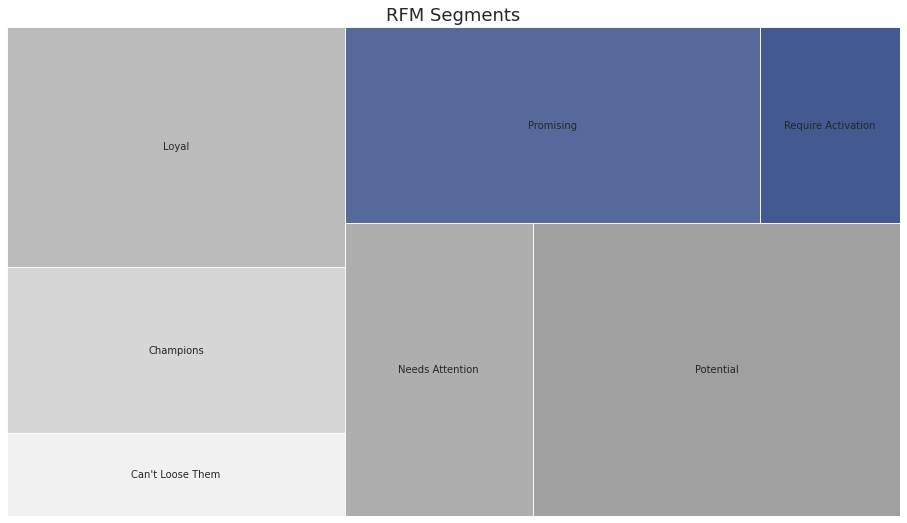

In [ ]:
import squarify

rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.9,color=['#f0f0f0','#d2d2d2','#b4b4b4','#a5a5a5','#969696','#425a90','#2e4884'])
plt.title("RFM Segments",fontsize=18)
plt.axis('off')
plt.show()


In [ ]:
rfm.head()

,recency,frequency,monetary,f_quartile,r_quartile,m_quartile,RFM_Score,RFM_Score_s,RFM_Level
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,1,4,3,413,8,Champions
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,1,4,1,411,6,Potential
0000f46a3911fa3c0805444483337064,541,1,86.22,1,1,2,112,4,Needs Attention
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,1,2,1,211,4,Needs Attention
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,1,2,3,213,6,Potential


In [ ]:
rfm.to_pickle('rfm.pkl')
df.to_pickle('final.pkl')